<a href="https://colab.research.google.com/github/kotgirep/clusteringalgos/blob/main/255GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CMPE255-Assignment: GMM

Data set: Covid 19 patients data set downloaded from Kaggle.

Business value: Helpful for people or organizations who are keeping track of covid 19 patients record.( like hospitals )

In this assignment, I am applying Gaussian mixture model algoritham to my covid19 patients dataset and selectiong other algoritham which is Birch and in the last comparing this recent clustering with previous k-means.

Import the libraries

In [1]:
# Import the required libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")

Reading the CSV File

In [3]:
#Read the data from csv file
df_data = pd.read_csv('/content/covid_19_data (1).csv',sep=',')
#Read data from file
df_data = df_data.sample(n=10000,random_state=24)
df_data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
245412,245413,03/11/2021,Altai Republic,Russia,2021-04-02 15:13:53,16379.0,181.0,16166.0
63795,63796,07/13/2020,Ostergotland,Sweden,2021-04-02 15:13:53,3411.0,224.0,0.0
122512,122513,09/30/2020,Himachal Pradesh,India,2021-04-02 15:13:53,14976.0,186.0,11390.0
151705,151706,11/08/2020,Islamabad,Pakistan,2021-04-02 15:13:53,21861.0,241.0,19120.0
22187,22188,05/06/2020,NaN,Barbados,2021-04-02 15:13:53,82.0,7.0,47.0


Get data information from dataset

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 245412 to 87867
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              10000 non-null  int64  
 1   ObservationDate  10000 non-null  object 
 2   Province/State   7381 non-null   object 
 3   Country/Region   10000 non-null  object 
 4   Last Update      10000 non-null  object 
 5   Confirmed        10000 non-null  float64
 6   Deaths           10000 non-null  float64
 7   Recovered        10000 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 703.1+ KB


Check if there are any missing values in the dataset

In [6]:
df_data.isnull().mean() * 100

SNo                 0.00
ObservationDate     0.00
Province/State     26.19
Country/Region      0.00
Last Update         0.00
Confirmed           0.00
Deaths              0.00
Recovered           0.00
dtype: float64

Drop the missing values

In [7]:
df = pd.DataFrame.dropna(df_data,axis=0,how='any')

Verify if all the missing vales are dropped

In [8]:
df.isnull().mean() * 100

SNo                0.0
ObservationDate    0.0
Province/State     0.0
Country/Region     0.0
Last Update        0.0
Confirmed          0.0
Deaths             0.0
Recovered          0.0
dtype: float64

Retrieve all the unique Country associated with the dataset

In [9]:
df['Country/Region'].unique()

array(['Russia', 'Sweden', 'India', 'Pakistan', 'Brazil', 'Chile', 'US',
       'Mainland China', 'Canada', 'Japan', 'Netherlands', 'Spain',
       'Australia', 'Peru', 'Mexico', 'Italy', 'Belgium', 'Hong Kong',
       'France', 'Germany', 'Ukraine', 'UK', 'Colombia', 'Denmark',
       'Taiwan', 'Macau', 'Others', 'China'], dtype=object)

In [10]:
df_without_lb = df.drop(['Country/Region'], axis=1)

Label Encoding : Encoding the categorical feature to numerical

In [11]:
df_without_lb.loc[:,'Province/State'] = LabelEncoder().fit_transform(df.loc[:,'Province/State'].copy())
df_without_lb.loc[:,'Country/Region'] = LabelEncoder().fit_transform(df.loc[:,'Country/Region'].copy())
df_without_lb.loc[:,'Last Update'] = LabelEncoder().fit_transform(df.loc[:,'Last Update'].copy())
df_without_lb.loc[:,'ObservationDate'] = LabelEncoder().fit_transform(df.loc[:,'ObservationDate'].copy())

df_without_lb

,SNo,ObservationDate,Province/State,Last Update,Confirmed,Deaths,Recovered,Country/Region
245412,245413,111,11,156,16379.0,181.0,16166.0,21
63795,63796,312,400,156,3411.0,224.0,0.0,23
122512,122513,391,193,156,14976.0,186.0,11390.0,11
151705,151706,430,213,156,21861.0,241.0,19120.0,19
71953,71954,323,397,156,5447.0,81.0,4102.0,21
...,...,...,...,...,...,...,...,...
122116,122117,390,559,156,1029.0,31.0,0.0,23
95538,95539,355,78,156,684221.0,12418.0,0.0,26
275446,275447,188,214,174,1577.0,29.0,1538.0,25
228180,228181,66,384,156,38593.0,2740.0,0.0,16


In [12]:
df_without_lb_np  = df_without_lb.to_numpy()
df_without_lb_np.shape

(7381, 8)

In [13]:
# Selecting top 10 features using chi2 score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_top10=SelectKBest(chi2,k=8)
chi2_test=chi2_top10.fit_transform(df_without_lb,df['Country/Region'])

Retrive all the unique country/regions in a dataset

In [14]:
df['Country/Region'].unique()

array(['Russia', 'Sweden', 'India', 'Pakistan', 'Brazil', 'Chile', 'US',
       'Mainland China', 'Canada', 'Japan', 'Netherlands', 'Spain',
       'Australia', 'Peru', 'Mexico', 'Italy', 'Belgium', 'Hong Kong',
       'France', 'Germany', 'Ukraine', 'UK', 'Colombia', 'Denmark',
       'Taiwan', 'Macau', 'Others', 'China'], dtype=object)

Applying Elbow method to find out number of k number of cluster

Text(0.5, 1.0, 'Elbow method to find out k number of clusters')

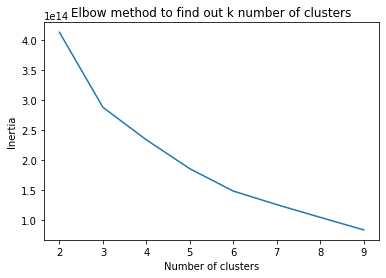

In [24]:
# Applying elbow method to see how many clusters would be a good fit for the dataset
sc = [KMeans(n_clusters=i+2).fit(chi2_test).inertia_ for i in range(8)]
sns.lineplot(np.arange(2,10),sc)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Elbow method to find out k number of clusters")

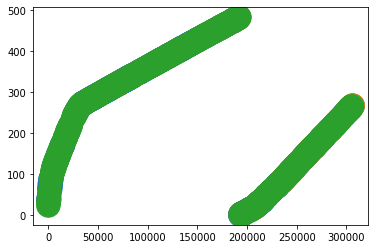

In [27]:
# GMM Clustering on the features extracted using chi2 test
from sklearn.mixture import GaussianMixture
import numpy 
import matplotlib
import matplotlib.pyplot as plt

gmm=GaussianMixture(n_components=3)
gmm.fit(chi2_test)

#pregmmdictions from gmm
lbl = gmm.predict(chi2_test)
df_gmm = pd.DataFrame(lbl)
df_gmm
clusters = numpy.unique(df_gmm)
# create scatter plot for samples from each cluster
for clst in clusters:
	# retrievet index of row for samples with this cluster
	row_index = numpy.where(df_gmm == clst)
	# creating scatter of the samples from features first,second and third
	matplotlib.pyplot.scatter(chi2_test[row_index, 0], chi2_test[row_index, 1],chi2_test[row_index, 2])
# draw a plot using matplot library
matplotlib.pyplot.show()

Finding out silhouette score for cluster=3 and gaussian model with chi square test

In [28]:
from sklearn.metrics import  silhouette_score
sil_avg = silhouette_score(chi2_test, df_gmm[0])
print("For n_clusters = 3 and GaussianMixture model with chi2 test","The silhouette_score is :", sil_avg)

For n_clusters = 3 and GaussianMixture model with chi2 test The silhouette_score is : 0.08312227189261377


In [29]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(df['Country/Region'],df_gmm[0])

0.13254657816408535